# Stellar Classification using Photometric data

# Summary

In this report, we attempt to build a classification model using logistic regression which uses photometric measurements from telescopes to classify stars under the Morgan-Keenan system. Our final classifier performed poorly with final accuracy of **0.326** on testing data set with a tendency to classify stars as one class cooler than its actual class type. Our model can only classify stars into 4 main classes due to the small sample size. It is recommended that further study using larger sample sizes and methods to improve the classification model.

# Introduction



Current and future astronomical surveys will observe hundred of thousands of objects each year. Due to the massive amount of spectroscopic and photometric data produced, an automated stellar classification process has become important in the field of astronomy in the past few years.

In astronomy, understanding the spectral characteristics of celestial objects serves as a fundamental pillar for unraveling the mysteries of the cosmos. Spectral classification, a cornerstone of astronomical research, enables us to discern the chemical composition, temperature, and evolutionary stage of stars, galaxies, and other celestial bodies. In the earliest days it was based on mass and temperature; however, our modern classification system has evolved and we classify stars based on the Morgan–Keenan (MK) system (Morgan et al. 1943) which group stars into 7 classes based on their spectral characteristics. Under the MK system, astronomers analyse electromagnetic radiation from stars to determine its class. These electromagnetic spectrum have dark lines to determine which and how abundant elements are present in the star. The 7 classes in the MK system - O, B, A, F, G, K, and M - are sequenced from the hottest (O type) to the coolest (K type) which also exhibits a certain characteristic that is very visible - colour. Hence in this report, we will classify stars using photometric data and in the Discussion section, we will evaluate whether this is a reliable alternative for the traditional method of comparing the best fit of the spectra to that of templates using statistical tests (Duan et al. 2009).


### Definitions

**Photometry**: the measurement of the flux or intensity of an astronomical object's electromagnetic radiation

The photometric system we're using to classify star types is the *Sloan* system (add reference) used by the Sloan Digital Sky Survey. The system measures the intensity of electromagnetic radition from stars at 5 bands:
- *u* (345nm)
- *g* (475nm which is a light blue in the visible spectrum)
- *r* (622nm which is orange)
- *i* (763nm which is deep red)
- *z* (905nm)

# Methods & Results

## Data

This report has made use of the NASA Exoplanet Archive, which is operated by the California Institute of Technology, under contract with the National Aeronautics and Space Administration under the Exoplanet Exploration Program. NASA Exoplanet Archive collects data from various sources, including ground-based observatories and space telescopes such as the Kepler Space Telescope and the Transiting Exoplanet Survey Satellite (TESS). The dataset is we're using is their [Planetary Systems dataset](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=PS) which has the columns of names, spectral type and measurements using Sloan photometric system selected.

The Python programming language (Van Rossum and Drake, 2009) and the following Python packages were used to perform the analysis: matplotlib (Hunter, 2007), scikit-learn (Pedregosa et al., 2011) and Pandas (McKinney, 2010).


### Imports

First of all, let's import the packages we will use to carry out the analysis and download the dataset. For our analysis we primarily used sklearn and pandas for our classification analysis as well as matplotlib for our visualizations.


In [10]:
import pandas as pd
import requests
import os
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


### Reading the Dataset

We then download the dataset of interest; the Expoplanet Systems dataset from NASA, containing information about measurements of planets and stars. We are interested in the spectral type of stars given a subset of these measurements.


In [11]:
current_date = datetime.now().date().strftime("%Y-%m-%d")

raw_data_dir = os.path.join("data", "raw")
raw_data_path = os.path.join(raw_data_dir, f"{current_date}_planet-systems.csv")

# make directory where we store our raw data
os.makedirs(raw_data_dir, exist_ok=True)

# check if we already have the dataset downloaded
if len(os.listdir(raw_data_dir)) != 0:
    print(len(os.listdir(raw_data_dir)))
    print(f"Using already existing dataset under {raw_data_dir}")
else:
    # download the raw data as CSV under the raw data directory
    url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/IceTable/nph-iceTblDownload"
    print(f"Downloading Planet Systems dataset from {url}")

    # define an HTTP request
    payload = {
        "workspace": "2024.02.29_21.58.35_020450/TblView/2024.03.02_14.52.28_004142",
        "useTimestamp": "1",
        "table": "/exodata/kvmexoweb/ExoTables/PS.tbl",
        "format": "CSV",
        "user": "",
        "label": "*",
        "columns": "pl_name_display,st_spectype,sy_umagstr,sy_gmagstr,sy_rmagstr,sy_imagstr,sy_zmagstr",
        "rows": "both",
        "mission": "ExoplanetArchive"
    }
    response = requests.get(url, params=payload)

    # assume request was successfull and access the downloaded content    
    raw_data = response.content

    # write downloaded content into a file under the raw data directory
    with open(raw_data_path, "wb") as f:
        f.write(raw_data)

# df holds the expolanet dataset as a DataFrame object
df = pd.read_csv(
    raw_data_path,
    header = 23, # 24-1=23
    dtype = {'pl_name' : 'string', 'st_spectype' : 'string'}
)

# remove columns in the dataset that have 'err' in their name
filtered_columns = [col for col in df.columns if 'err' not in col]

exoplanet_data = df[filtered_columns]

exoplanet_data

1
Using already existing dataset under data\raw


,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
0,11 Com b,<NA>,NaN,NaN,NaN,NaN,NaN
1,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
2,11 Com b,G8 III,NaN,NaN,NaN,NaN,NaN
3,11 UMi b,<NA>,NaN,NaN,NaN,NaN,NaN
4,11 UMi b,<NA>,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
35843,ups And d,<NA>,NaN,NaN,NaN,NaN,NaN
35844,ups Leo b,G9 III,NaN,NaN,NaN,NaN,NaN
35845,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN
35846,xi Aql b,<NA>,NaN,NaN,NaN,NaN,NaN



### Data EDA and Wrangling

This dataset from NASA's Exoplanet Archive include all planets and stars. Therefore we will wrangle the dataset such that it only contain stars with Sloan magnitudes for photometric measurements.


In [12]:
# pre-process data
only_stars_data = exoplanet_data.dropna(subset = ['st_spectype',
                                                  'sy_umag',
                                                  'sy_gmag',
                                                  'sy_rmag',
                                                  'sy_imag',
                                                  'sy_zmag'])
only_stars_data.info

<bound method DataFrame.info of             pl_name st_spectype  sy_umag  sy_gmag    sy_rmag   sy_imag  \
180    BD+20 2457 b       K2 II  14.9129  10.5155   9.277390   8.84049   
182    BD+20 2457 c       K2 II  14.9129  10.5155   9.277390   8.84049   
183     BD+20 274 b      K5 III  14.3374  10.1863   8.941711   8.49228   
210      BD-17 63 b        K5 V  14.1468  10.2994   9.211040   8.86964   
215        CD Cet b      M5.0 V  17.4608  15.0603  13.949400  14.18480   
...             ...         ...      ...      ...        ...       ...   
35641        XO-1 b        G1 V  14.8365  11.7844  11.049500  10.86850   
35701        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35702        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35703        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   
35704        XO-5 b        G8 V  15.3529  15.0080  11.988900  11.82070   

        sy_zmag  
180     8.97784  
182     8.97784  
183     8.90440  
210    

In [13]:
# we are only interested in the first letter of spectral type, which becomes our y later
only_stars_data_copy = only_stars_data.copy() # needed to avoid warning raised by pandas
only_stars_data_copy["st_spectype"] = only_stars_data_copy['st_spectype'].transform(lambda x: x[0])
only_stars_data_copy = only_stars_data_copy.loc[only_stars_data_copy['st_spectype'].isin(['O','B', 'A', 'F', 'G', 'K', 'M'])]
only_stars_data_copy["st_spectype"] = only_stars_data_copy["st_spectype"].astype("category")
only_stars_data = only_stars_data_copy

only_stars_data

,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
180,BD+20 2457 b,K,14.9129,10.5155,9.277390,8.84049,8.97784
182,BD+20 2457 c,K,14.9129,10.5155,9.277390,8.84049,8.97784
183,BD+20 274 b,K,14.3374,10.1863,8.941711,8.49228,8.90440
210,BD-17 63 b,K,14.1468,10.2994,9.211040,8.86964,9.00956
215,CD Cet b,M,17.4608,15.0603,13.949400,14.18480,13.29560
...,...,...,...,...,...,...,...
35641,XO-1 b,G,14.8365,11.7844,11.049500,10.86850,11.31440
35701,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35702,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610
35703,XO-5 b,G,15.3529,15.0080,11.988900,11.82070,13.65610


**Note**: 
In order to run classification models on our dataset, we had to remove the NA values from our magnitudes. We were planning to incorporate `SimpleImputer()` into our pipeline during data preprocessing, but about 2200 rows contained NA values, so we thought it was best to simply drop them. This explains the drastic decrease in observations.

### Variables:

`st_spectype`: Classification of the star based on their spectral characteristics following the Morgan-Keenan system

`sy_umag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) u band, in units of magnitudes

`sy_gmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) g band, in units of magnitudes

`sy_rmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) r band, in units of magnitudes

`sy_imag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) i band, in units of magnitudes

`sy_zmag`: Brightness of the host star as measured using the Sloan Digital Sky Survey (SDSS) z band, in units of magnitudes

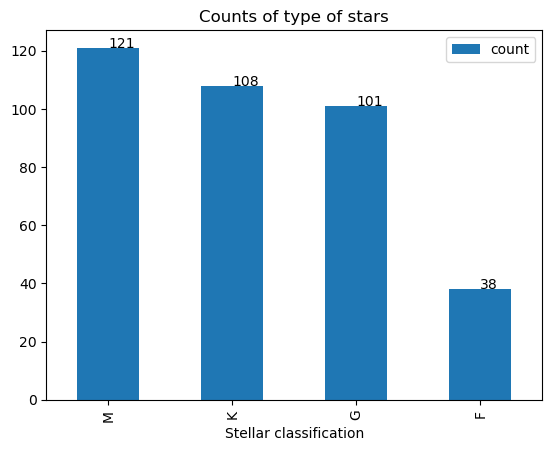

In [22]:
types_summ = pd.DataFrame(only_stars_data["st_spectype"].value_counts())

fig, ax = plt.subplots(1, 1)
types_summ.plot.bar(xlabel = 'Stellar classification', title="Counts of type of stars", ax=ax)

for col in types_summ.columns:
    for id, val in enumerate(types_summ[col]):
        ax.text(id, val, str(val))

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3357755374.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').describe())


sy_umag                                                  \
              count       mean       std      min      25%      50%   
st_spectype                                                           
F              38.0  15.006642  0.766401  13.7542  14.7063  14.8961   
G             101.0  15.187605  0.517554  13.9531  15.0087  15.1660   
K             108.0  15.638826  0.853421  13.0932  15.0413  15.6091   
M             121.0  17.467183  1.812482  14.5112  15.7198  17.2832   

                                 
                   75%      max  
st_spectype                      
F            15.233200  17.9494  
G            15.486200  16.9794  
K            15.845975  17.9905  
M            19.189500  21.2975

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3357755374.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').boxplot()


F         Axes(0.1,0.559091;0.363636x0.340909)
G    Axes(0.536364,0.559091;0.363636x0.340909)
K             Axes(0.1,0.15;0.363636x0.340909)
M        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

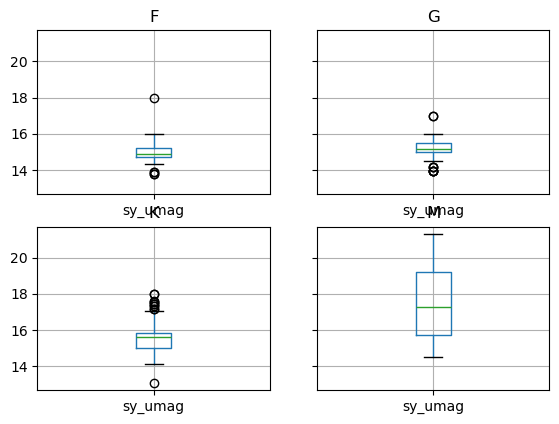

In [29]:
display(only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').describe())

only_stars_data[['st_spectype', 'sy_umag']].groupby('st_spectype').boxplot()

For *M*-class of stars, the magnitude of the *u*-band is much higher than the remaining classes at 17.3 at the median.

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\4262512925.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').describe())


sy_gmag                                                     \
              count       mean       std       min        25%      50%   
st_spectype                                                              
F              38.0  13.402132  1.491581  10.76140  12.064725  13.2435   
G             101.0  13.383252  1.038540  10.49290  12.721300  13.3064   
K             108.0  13.208701  1.767100  10.01390  11.312600  13.5205   
M             121.0  14.899588  2.070953   9.91288  13.021000  15.3392   

                                 
                   75%      max  
st_spectype                      
F            14.971975  16.4513  
G            14.108400  15.3870  
K            14.894800  16.0648  
M            16.452000  18.7296

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\4262512925.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').boxplot()


F         Axes(0.1,0.559091;0.363636x0.340909)
G    Axes(0.536364,0.559091;0.363636x0.340909)
K             Axes(0.1,0.15;0.363636x0.340909)
M        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

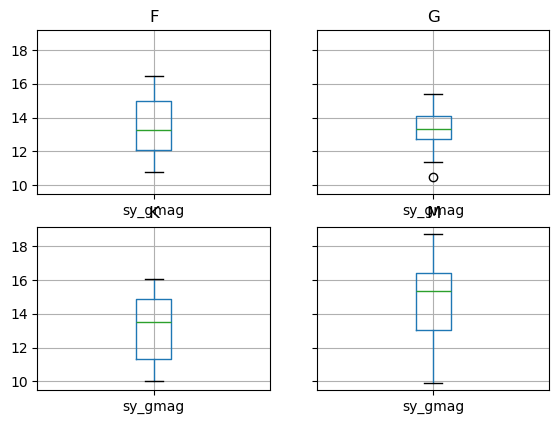

In [30]:
display(only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').describe())
only_stars_data[['st_spectype', 'sy_gmag']].groupby('st_spectype').boxplot()

Again, for *M*-class of stars, the magnitude of the *g*-band is much higher than the remaining classes at 15.3 at the median.

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\1369983850.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').describe())


sy_rmag                                                    \
              count       mean       std       min      25%       50%   
st_spectype                                                             
F              38.0  12.618895  1.189809  10.31190  11.6961  12.58465   
G             101.0  12.600822  1.094898   9.62924  11.9889  12.20680   
K             108.0  11.951414  1.701821   8.75954  10.5964  12.06500   
M             121.0  13.427750  2.009548   8.46313  11.6746  13.48880   

                                 
                   75%      max  
st_spectype                      
F            13.383525  15.7952  
G            13.115700  15.3971  
K            13.396700  15.6566  
M            15.271700  16.8600

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\1369983850.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').boxplot()


F         Axes(0.1,0.559091;0.363636x0.340909)
G    Axes(0.536364,0.559091;0.363636x0.340909)
K             Axes(0.1,0.15;0.363636x0.340909)
M        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

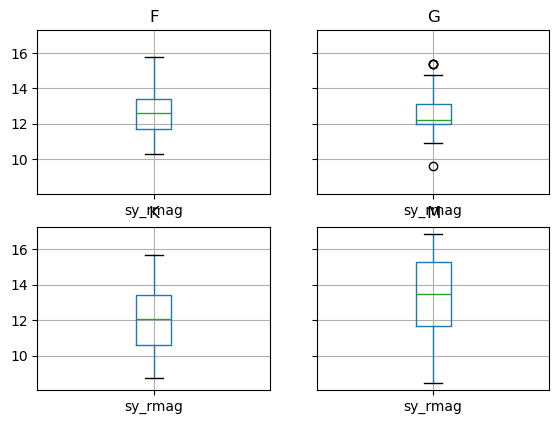

In [31]:
display(only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').describe())
only_stars_data[['st_spectype', 'sy_rmag']].groupby('st_spectype').boxplot()

Again, for *M*-class of stars, the magnitude of the *r*-band is higher than the remaining classes at 13.4 at the median.

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3572468148.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').describe())


sy_imag                                                            \
              count       mean       std       min      25%      50%      75%   
st_spectype                                                                     
F              38.0  12.576882  1.308776  10.27340  11.6210  12.4579  13.1710   
G             101.0  12.403310  1.144568   9.44522  11.6309  11.9824  12.8354   
K             108.0  11.911296  1.565200   8.42724  10.4417  12.0708  13.1720   
M             121.0  12.672058  2.167534   7.75055  10.9702  12.9151  14.3142   

                      
                 max  
st_spectype           
F            15.4941  
G            16.6984  
K            14.5213  
M            17.9112

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3572468148.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').boxplot()


F         Axes(0.1,0.559091;0.363636x0.340909)
G    Axes(0.536364,0.559091;0.363636x0.340909)
K             Axes(0.1,0.15;0.363636x0.340909)
M        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

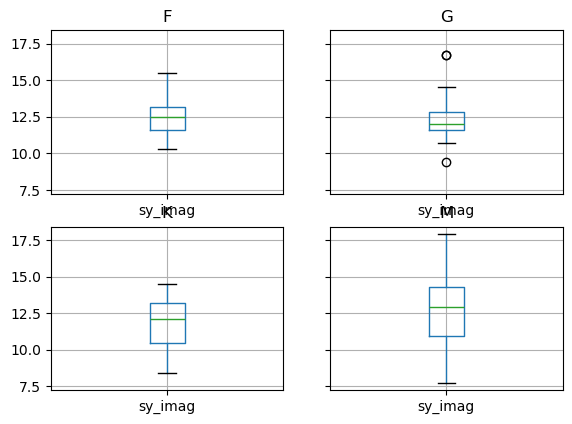

In [32]:
display(only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').describe())
only_stars_data[['st_spectype', 'sy_imag']].groupby('st_spectype').boxplot()

For every class of stars, the magnitude at the *i*-band is similar.

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3449522543.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').describe())


sy_zmag                                                    \
              count       mean       std       min      25%       50%   
st_spectype                                                             
F              38.0  13.088816  0.937463  10.47840  12.9808  13.17575   
G             101.0  12.970841  0.695333   9.60484  12.7326  13.04600   
K             108.0  11.921180  1.529773   7.85169  10.8606  12.65380   
M             121.0  12.173696  1.659763   7.76319  11.0226  12.71950   

                                 
                   75%      max  
st_spectype                      
F            13.463275  15.2871  
G            13.356600  14.4078  
K            13.240300  13.9587  
M            13.256500  15.1016

C:\Users\VietNgo\AppData\Local\Temp\ipykernel_76144\3449522543.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').boxplot()


F         Axes(0.1,0.559091;0.363636x0.340909)
G    Axes(0.536364,0.559091;0.363636x0.340909)
K             Axes(0.1,0.15;0.363636x0.340909)
M        Axes(0.536364,0.15;0.363636x0.340909)
dtype: object

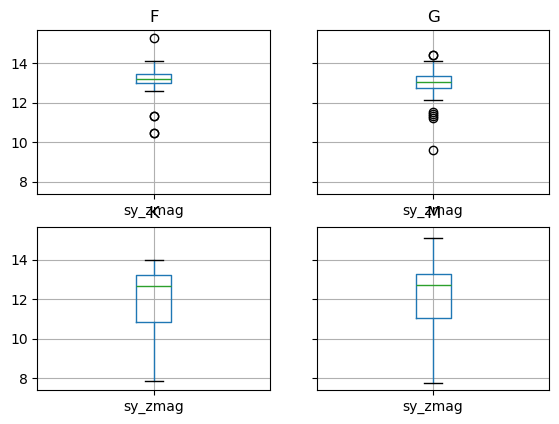

In [33]:
display(only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').describe())
only_stars_data[['st_spectype', 'sy_zmag']].groupby('st_spectype').boxplot()

For every class of stars, the magnitude at the *i*-band is similar.

## Classification Analysis

In [14]:
only_stars_data.describe(include="all")

,pl_name,st_spectype,sy_umag,sy_gmag,sy_rmag,sy_imag,sy_zmag
count,368,368,368.000000,368.000000,368.000000,368.000000,368.000000
unique,217,4,NaN,NaN,NaN,NaN,NaN
top,K2-3 c,M,NaN,NaN,NaN,NaN,NaN
freq,5,121,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16.050877,13.832553,12.683998,12.365203,12.412866
std,NaN,NaN,1.564612,1.842717,1.725352,1.696119,1.423512
min,NaN,NaN,13.093200,9.912880,8.463130,7.750550,7.763190
25%,NaN,NaN,15.098200,12.489000,11.674600,11.386000,11.892375
50%,NaN,NaN,15.549600,13.759000,12.539900,12.143250,12.839400
75%,NaN,NaN,16.493975,15.199500,13.725700,13.436075,13.297600


In [15]:
# We will be trying to predict what st_spectype a star has
y = only_stars_data["st_spectype"]

# Our predictors will be the following 5 features
X = only_stars_data[["sy_umag", "sy_gmag", "sy_rmag", "sy_imag", "sy_zmag"]]

# Creating a 75% train test split to run on our data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=123)


In [16]:
y_train.value_counts(normalize=True)

st_spectype
M    0.311284
G    0.307393
K    0.276265
F    0.105058
Name: proportion, dtype: float64

We have a pretty spread out class with no major class imbalance.

In [17]:
# Logistic Regression cross validation
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.008728
score_time     0.000999
test_score     0.688989
train_score    0.705247
dtype: float64

## Confusion Matrix
One way to get a better understanding of the errors is by looking at 
- How well the classifier is identifying each class.
- Which classes are most frequently confused with each other.
- Overall accuracy, along with class-specific metrics like precision, recall, and F1-score for multi-class classification problems.


It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. So let's create a validation set. 

In [18]:
X_train_2, X_valid, y_train_2, y_valid = train_test_split(
    X_train, y_train, test_size=0.3, random_state=123
)

In [19]:
from sklearn.metrics import confusion_matrix

# Train the model on the training set
pipe.fit(X_train, y_train)

# Predict y values for the validation set
predictions = pipe.predict(X_valid)

# Compare the predicted y values with actual y values of the validaiton set using the confusion matrix
cm = confusion_matrix(y_valid, predictions)
print(cm)

[[ 0  9  0  0]
 [ 0 18  6  0]
 [ 0  2 14  3]
 [ 0  0  2 24]]


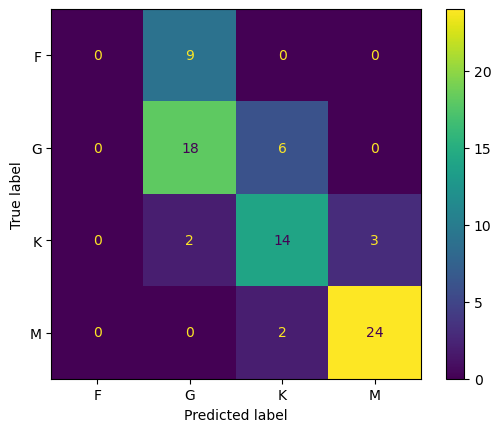

In [20]:
#For better interpretation, we will visualize the confusion matrix using 'ConfusionMatrixDisplay'
ConfusionMatrixDisplay.from_predictions(y_valid, predictions)

plt.show()

In [21]:
# RandomForest Classifier
rfc = RandomForestClassifier(n_estimators=275, random_state=123)
pipe2 = make_pipeline(StandardScaler(), rfc)

# Calculate mean cross_val_score score of test scores
cv_results = cross_val_score(pipe2, X, y, cv=5, scoring='accuracy')
print("Mean cross validation score:", cv_results.mean())

# We are fitting our classifier to our dataset
pipe2.fit(X_train, y_train)

# Calculating the accuracy of our predictions made on the test set
predictions = rfc.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

pd.DataFrame(cross_validate(pipe2, X_train, y_train, return_train_score=True)).mean()


Mean cross validation score: 0.6469825990373936
Accuracy: 0.36936936936936937


C:\Users\VietNgo\miniconda3\envs\dsci-310-group16\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


fit_time       0.179932
score_time     0.005801
test_score     0.852413
train_score    0.987360
dtype: float64

Ultimately from our validation scores, we achieve a much higher test score from our scaled data with the RandomForestClassifier model of 0.750 compared to LogisticRegression model of 0.694. However our accuracy score is quite low at 0.326.

# Discussion

Our model yielded pretty average results with final overall accuracy of 0.326. This model is not good enough for an automated stellar classification process. In addition, our model can only classify stars into 4 classes due to the limited sample size. However these 4 classes make up about 99.8% of stellar population (Ledrew, 2001) so being unable to classify stars into remaining 3 classes isn't as big of an issue. Looking at the confusion matrix, we can see that our model tend to classify stars as cooler than they actually are (e.g: 9 stars were classified as *G* but were actually *F* class). In order to improve this model, a larger sample size would help like using the Sloan Digital Sky Survey dataset instead. Another way to improve the model is to explore other classification methods such as k nearest neighbours. Finally, using another photometric system such as UBV could help since the bands are more seperated resulting in larger difference in magnitudes between star classes. More research into other classification methods could most likely yield higher accuracy.

# References

- Morgan, W. W., Keenan, P. C., & Kellman, E. (1942). An atlas of stellar spectra. University of Chicago.
- Duan, F. Q., Liu, R., Guo, P., Zhou, M. Q., & Wu, F. C. (2009). Automated spectral classification using template matching. Research in Astronomy and Astrophysics, 9(3), 341.
- Van Rossum, G., & Drake Jr, F. L. (1995). Python tutorial (Vol. 620). Amsterdam, The Netherlands: Centrum voor Wiskunde en Informatica.
- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in science & engineering, 9(03), 90-95.
- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... & Duchesnay, É. (2011). Scikit-learn: Machine learning in Python. the Journal of machine Learning research, 12, 2825-2830.
- McKinney, W. (2010, June). Data structures for statistical computing in python. In Proceedings of the 9th Python in Science Conference (Vol. 445, No. 1, pp. 51-56).
- Ledrew, G. (2001). The real starry sky. Journal of the Royal Astronomical Society of Canada, Vol. 95, p. 32, 95, 32.